In [10]:
%%writefile Ind_New_Tech_2023.py

import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tools.Sample_Tools as smpl

from base.JuUnits import excute_for_multidates

from sklearn import linear_model



def get_cur_ret(stock_df):
    cur_ret = smpl.get_current_return(stock_df,'close')
    cur_ret.name = 'ret'
    return cur_ret

def get_turn_cv(stock_df):
    turnover = stock_df['volume'] / (stock_df['lshares'] *100) # Êâã/‰∏áËÇ°
    # # # Êç¢ÊâãÁéáÁ®≥ÂÆöÊÄß=ùë†ùë°ùëë(ÊúÄËøë‰∏ÄÊÆµÊó∂Èó¥Êó•Â∫¶Êç¢ÊâãÁéáÂ∫èÂàó) #‰∏çÂ§™Ë°å
    turn_std_1m = excute_for_multidates(turnover, lambda x:x.rolling(22).std(), level=1)
    # turn_std_3m = excute_for_multidates(turnover, lambda x:x.rolling(66).std(), level=1)

    # # Êç¢ÊâãÁéáÂèòÂºÇÁ≥ªÊï∞=ùë†ùë°ùëë(ÊúÄËøë‰∏ÄÊÆµÊó∂Èó¥Êó•Â∫¶Êç¢ÊâãÁéáÂ∫èÂàó)/ùëöùëíùëéùëõ(ÊúÄËøë‰∏ÄÊÆµÊó∂Èó¥Êó•Â∫¶Êç¢ÊâãÁéáÂ∫èÂàó)
    turn_mean_1m = excute_for_multidates(turnover, lambda x:x.rolling(22).mean(), level=1)
    # turn_mean_3m = excute_for_multidates(turnover, lambda x:x.rolling(66).mean(), level=1)
    
    turn_cv_1m = turn_std_1m/turn_mean_1m # Â•Ω
    # turn_cv_3m = turn_std_3m/turn_mean_3m 
    turn_cv_1m.name = 'turn_cv'
    return turn_cv_1m

# # ÂºÇÂ∏∏Êç¢ÊâãÁéá=(ùëöùëíùëéùëõ(Áü≠ÊúüÊó•Â∫¶Êç¢ÊâãÁéá)‚àíùëöùëíùëéùëõ(ÈïøÊúüÊó•Â∫¶Êç¢ÊâãÁéá)) /ùë†ùë°ùëë(ÈïøÊúüÊó•Â∫¶Êç¢ÊâãÁéá) #‰∏çÂ§™Ë°å
# turn_ext = (turn_std_1m - turn_std_3m)/turn_std_3m

def get_amihud(stock_df, cur_ret):
    cur_ret_abs = cur_ret.abs()
    # ÈùûÊµÅÂä®ÊÄß=ùëöùëíùëéùëõ(Êó•ÁªùÂØπÊî∂ÁõäÁéá/Êó•Êàê‰∫§È¢ù) # Â•Ω #‰∏çË¶ÅÂπ≥ÂùáÔºåÂπ≥ÂùáÂêé‰∏çÁÆ°ÊòØ‰ø°Âè∑ËøòÊòØÊî∂ÁõäËøòÊòØicÔºåÈÉΩÊòæËëó‰∏ãÈôçÔºå
    amihud = cur_ret_abs / stock_df['amount']
    amihud.name = 'amihud'
    return amihud

def get_amihud_adv(stock_df, cur_ret):
    cur_ret_abs = cur_ret.abs()
    # ÈùûÊµÅÂä®ÊÄß_ÊîπËøõ=ùëöùëíùëéùëõ(ÊúÄËøë‰∏ÄÊÆµÊó∂Èó¥Êó•ÁªùÂØπÊî∂ÁõäÁéáÂ∫èÂàó)/ùëöùëíùëéùëõ(ÊúÄËøë‰∏ÄÊÆµÊó∂Èó¥Êó•Êàê‰∫§È¢ùÂ∫èÂàó) # Â•Ω
    amihud_adv_5 = excute_for_multidates(cur_ret_abs, lambda x:x.rolling(5).mean(), level=1) / excute_for_multidates(stock_df['amount'], lambda x:x.rolling(5).mean(), level=1) 
    amihud_adv_5.name = 'amihud_adv'
    return amihud_adv_5

def get_amihud_negative(stock_df):
# Ë¥üÊî∂ÁõäÈùûÊµÅÂä®ÊÄß=ùëöùëíùëéùëõ(ÊúÄËøë‰∏ÄÊÆµÊó∂Èó¥Êó•ÁªùÂØπÊî∂ÁõäÁéáÂ∫èÂàó_Êî∂Áõä‰∏∫Ë¥ü)/ùëöùëíùëéùëõ(ÊúÄËøë‰∏ÄÊÆµÊó∂Èó¥Êó•Êàê‰∫§È¢ùÂ∫èÂàó_Êî∂Áõä‰∏∫Ë¥ü) # ‰∏ÄËà¨ÔºåÂáπÂûãÔºåÁ™óÂè£Ë∂äÂ§ß‰ø°Âè∑Ë∂äÊòéÊòæÔºå‰ΩÜÊòØÊÄªÊî∂ÁõäÂÜç‰∏ãÈôç„ÄÇ
    negative_ret = smpl.get_current_return(stock_df,'close')
    negative_ret[negative_ret>0]=0
    negative_ret = negative_ret.abs()
    amihud_negative_22 = excute_for_multidates(negative_ret, lambda x:x.rolling(22).mean(), level=1) / excute_for_multidates(stock_df['amount']*np.sign(negative_ret), lambda x:x.rolling(22).mean(), level=1) 
    amihud_negative_22.name = 'amihud_negative'
    return amihud_negative_22

def get_amihud_cv(stock_df, cur_ret):
    cur_ret_abs = cur_ret.abs()
    # ÈùûÊµÅÂä®ÊÄßÂèòÂºÇÁ≥ªÊï∞ = (ùë†ùë°ùëë(ÁªùÂØπÊî∂ÁõäÁéáÂ∫èÂàó)/ùëöùëíùëéùëõ(ÁªùÂØπÊî∂ÁõäÁéáÂ∫èÂàó)) / (ùë†ùë°ùëë(Êàê‰∫§È¢ùÂ∫èÂàó)/ùëöùëíùëéùëõ(Êàê‰∫§È¢ùÂ∫èÂàó)) # ‰∏ÄËà¨Ôºå‰ø°Âè∑‰∏çÊòØÈùûÂ∏∏ÊòæËëóÔºåicËøòË°åÔºåÈ´ò‰ΩéÂ∑ÆÂºÇÂ§ßÔºå‰∏≠Èó¥Ê≤°Âï•Â∑ÆÂºÇ‰∏îË∑üÁ¨¨‰∏ÄÂ∑ÆÂà´‰∏çÁÆóÂ§ß„ÄÇ
    numerator = excute_for_multidates(cur_ret_abs, lambda x:x.rolling(5).std(), level=1) / excute_for_multidates(cur_ret_abs, lambda x:x.rolling(5).ùëöùëíùëéùëõ(), level=1)
    denominator = excute_for_multidates(stock_df['amount'], lambda x:x.rolling(5).std(), level=1) / excute_for_multidates(stock_df['amount'], lambda x:x.rolling(5).ùëöùëíùëéùëõ(), level=1)
    amihud_cv_5 = numerator / denominator
    amihud_cv_5.name = 'amihud_cv'
    return amihud_cv_5


def get_obv(stock_df, cur_ret):
    # ùëÇùêµùëâ = ùë†ùë¢ùëö(ùë£ùëúùëôùë¢ùëöùëí); 
    # ùë£ùëúùëôùë¢ùëöùëí = {
    #           ùë£ùëúùëôùë¢ùëöùëí   ùëêùëôùëúùë†ùëí>ùëêùëôùëúùë†ùëí[1]
    #           ‚àíùë£ùëúùëôùë¢ùëöùëí  ùëêùëôùëúùë†ùëí<ùëêùëôùëúùë†ùëí[1]
    #           0        ùëêùëôùëúùë†ùëí=ùëêùëôùëúùë†ùëí[1]
    #          }
    obv = cur_ret * stock_df['volume'] 
    obv.name = 'obv'
    return obv

def get_pvc(stock_df):
    # Èáè‰ª∑Áõ∏ÂÖ≥ÊÄß = corr(close,volume) ##  Â•ΩÔºà10Â§©ÔºâÔºåÊ≥®ÊÑèÔºåÊÖ¢ÔºàÁ∫¶14mÔºâ
    # pvc_5 = excute_for_multidates(stock_df, lambda x:x['close'].rolling(5).apply(lambda xx:xx.corr(x.loc[xx.index]['volume'])),level=1)
    pvc_10 = excute_for_multidates(stock_df, lambda x:x['close'].rolling(10).apply(lambda xx:xx.corr(x.loc[xx.index]['volume'])),level=1)
    # pvc_22 = excute_for_multidates(stock_df, lambda x:x['close'].rolling(22).apply(lambda xx:xx.corr(x.loc[xx.index]['volume'])),level=1)
    pvc_10.name = 'pvc'
    return pvc_10

def get_pvc_optimize(stock_df,cur_ret,pvc):
    # Èáè‰ª∑Áõ∏ÂÖ≥ÊÄß_ÊîπËøõÂõ†Â≠ê ÊòØÈáè‰ª∑Áõ∏ÂÖ≥ÊÄßÂõ†Â≠êÂâîÈô§ÂØπÂ∫îÊúüÈôêÁöÑÊ∂®Ë∑åÂπÖÂíåÊàê‰∫§ÈáèÔºåÂâîÈô§ÂêéÁöÑ‰ø°ÊÅØËÉΩÊõ¥Âä†Á∫ØÁ≤π‰ΩìÁé∞Èáè‰ª∑Áõ∏ÂÖ≥Á®ãÂ∫¶„ÄÇËØ•Âõ†Â≠êÁöÑÊñπÂêë‰∏∫Ë¥ü„ÄÇ
    # Èáè‰ª∑Áõ∏ÂÖ≥ÊÄß_ÊîπËøõ = Èáè‰ª∑Áõ∏ÂÖ≥ÊÄß ‚àí ùõΩ1‚àóùëÖùëíùë° ‚àí ùõΩ2‚àóùëâùëúùëô ‚àí ùúÄ (‰∏épvcÁõ∏ÂèçÔºåÊïàÊûúÂíåË¥®ÈáèÂ∑Æ‰∏çÂ§öÔºå‰ΩÜicËæÉÂ∑Æ)
    pvc.name = 'pvc'
    def reg(df):
        X = df[['ret','volume']].values.reshape(-1, 2)

        model = linear_model.LinearRegression(fit_intercept=True, n_jobs=1)
        res = model.fit(X,df[['pvc']].values.reshape(-1, 1))

        predict = model.predict(X)
        resid = df['pvc'] - predict.flatten()
        return resid
    pvc_df = pd.concat([pvc, cur_ret, stock_df['volume']],axis=1).dropna()
    pvc_optimize = excute_for_multidates(pvc_df, lambda x:reg(x),level=1)
    pvc_optimize.name = 'pvc_optimize'
    return pvc_optimize



Overwriting Ind_New_Tech_2023.py


In [4]:
# from tools.Cacher import (CACHE_TYPE, save_cache,load_cache_adv,load_cache)

# tail = False
# if tail:
#     df_all = load_cache('all_tail_qfq',cache_type=CACHE_TYPE.STOCK).sort_index()
# else:
#     df_all = load_cache('all_train_qfq',cache_type=CACHE_TYPE.STOCK).sort_index()
# smpl.optimize_data_type(df_all)

# df_treated = pretreate_data(df_all)

# year = '2020'
# data_ = df_all.loc[year+'-01-03':year+'-12-28']


# ret = smpl.get_forward_return(data_,'close')
# ret.name = 'ret_forward'
# ret[np.abs(ret)>0.15]=np.nan

In [410]:
# import numpy as np
# import matplotlib.pyplot as plt
import pandas as pd

# a = (np.random.rand(10)+0.5)*100
# # np.random.shuffle(a)
# print(a)
# plt.bar(range(1,11),a)
# plt.show()
# # (a[0]-a[-1])/(a[1]-a[-2])
# print(  ((a[0]-a[-1]) + (a[1]-a[-2]))/((a[2]-a[-3])+(a[3]-a[-4])) +1e-06)
# a= a[::-1]
# print(  ((a[0]-a[-1])*0.7 + (a[1]-a[-2])*0.3)/((a[2]-a[-3])*0.3+(a[3]-a[-4])*0.7) +1e-06)

# y = np.random.rand(10).argsort() +1
# # y = np.array([5,4,3,2,1])
# np.random.shuffle(y)
# x = np.arange(1,11)
# print(y)
# plt.bar(x,y)
# plt.show()


# print((y[0]-y[-1])/(y[1]-y[-2]))
# print(  ((y[0]-y[-1]) + (y[1]-y[-2]) )/((y[2]-y[-3]) +(y[3]-y[-4]) ) +1e-06)
# print(  ((y[0]-y[-1])*0.7 + (y[1]-y[-2])*0.3)/((y[2]-y[-3])*0.3+(y[3]-y[-4])*0.7) +1e-06)
# print(np.linalg.lstsq(np.vstack([x,np.ones(len(x))]).T, y.reshape(-1,1),rcond=None)[0][0])



'green'

In [16]:
# p = pvc_5.loc[(slice(None),['000001','000002','000006'])]
# p.name = 'pvc'
# ret_a = cur_ret.loc[(slice(None),['000001','000002','000006'])]
# a = data_replenish['volume'].loc[(slice(None),['000001','000002','000006'])]

# tmp = pd.concat([p,ret_a,a],axis=1).dropna()


# 1ÔºâICÂÄºÁöÑÂùáÂÄº
# Ôºà2ÔºâICÂÄºÁöÑÊ†áÂáÜÂ∑Æ
# Ôºà3ÔºâICÂ§ß‰∫é0ÁöÑÊØî‰æã
# Ôºà4ÔºâICÁªùÂØπÂÄºÂ§ß‰∫é0.02ÁöÑÊØî‰æã
# Ôºà5ÔºâIR ÔºàIR = ICÂùáÂÄº/ICÊ†áÂáÜÂ∑ÆÔºâ

# Monotony Score  = lstsq.abs > 0.5


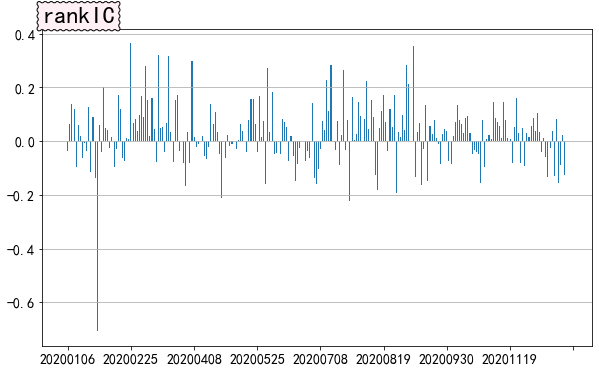

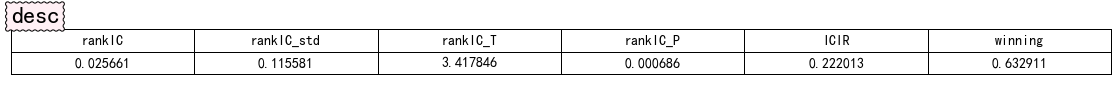

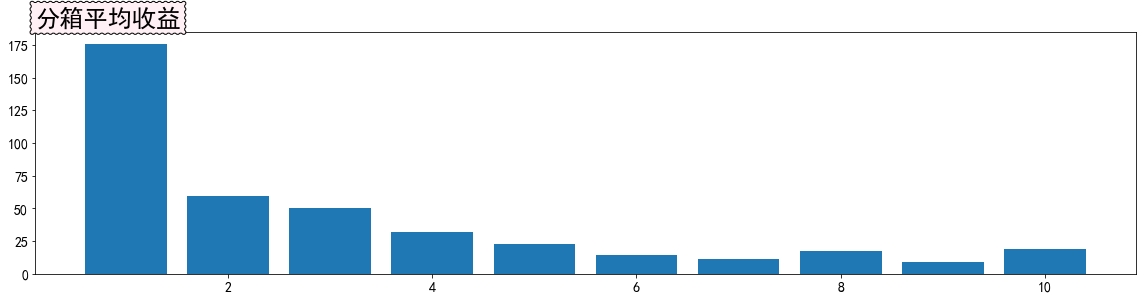

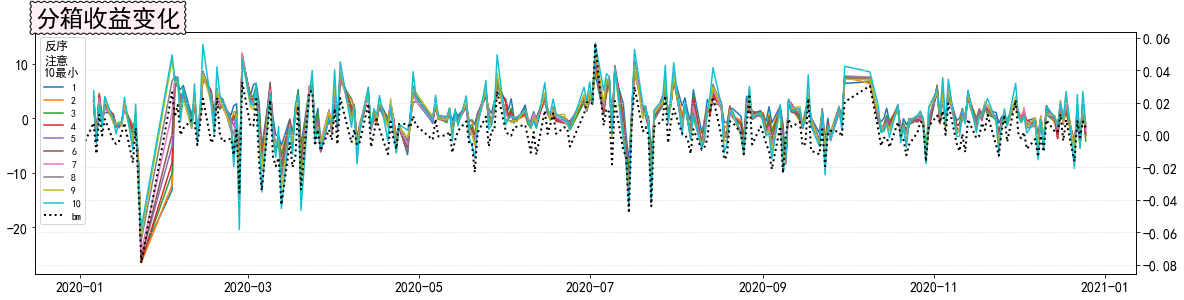

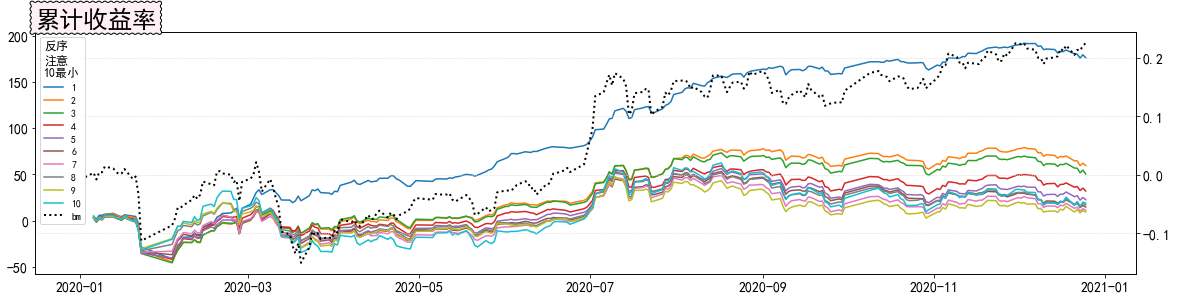

Wall time: 18.7 s


In [ ]:
%%time
from tools.Test_Tools_Simple import FactorTest

# %load_ext autoreload
# %autoreload 1
# %aimport tools.Test_Tools_Simple

fa = pd.DataFrame(amihud).dropna()
fa.columns=['xxx']
test = FactorTest(start=dates.min().strftime('%Y-%m-%d'),end=dates.max().strftime('%Y-%m-%d'),target_field='xxx',blenchmark_name='Ê≤™Ê∑±300', freq="d")
test.process_ind_simple(fa,ret,need_descript=True)
test.plot()


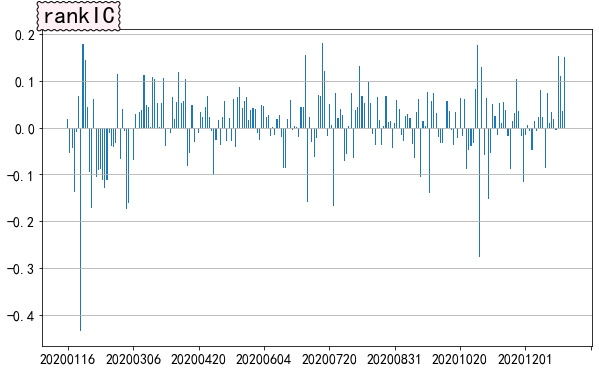

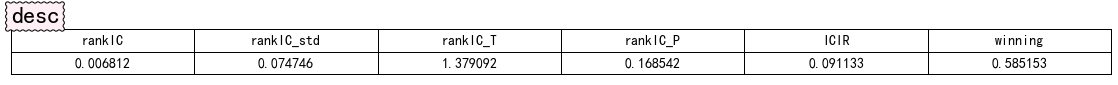

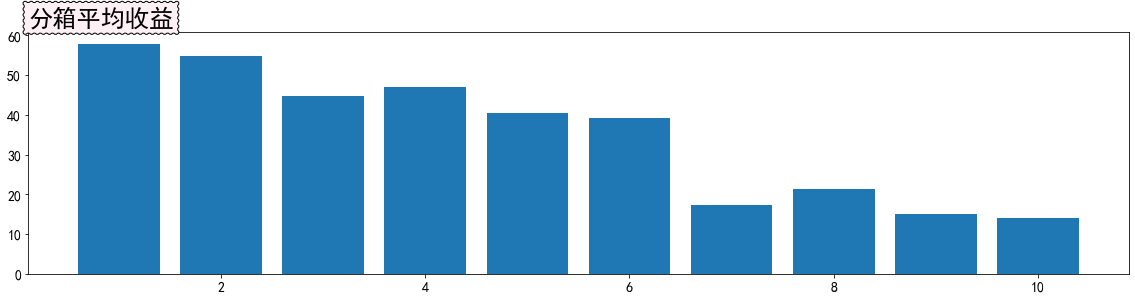

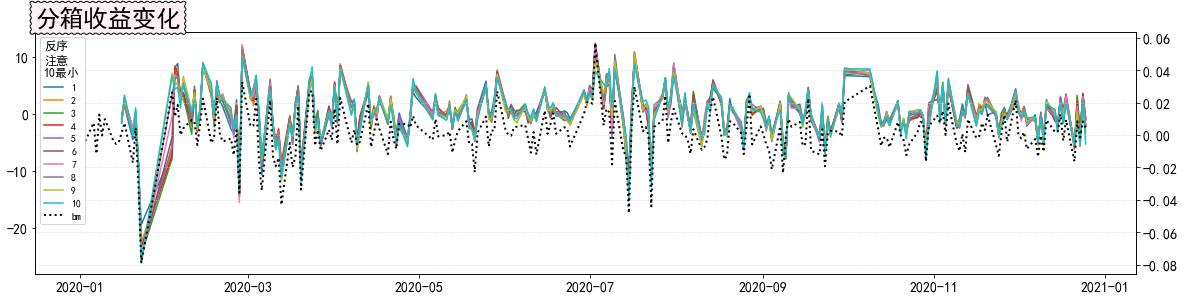

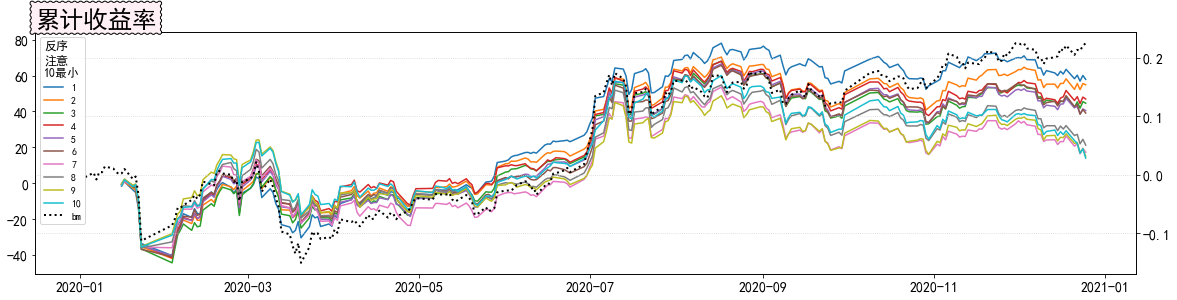

In [119]:
fa = pd.DataFrame(pvc_optimize).dropna()
fa.columns=['xxx']
test = FactorTest(start=dates.min().strftime('%Y-%m-%d'),end=dates.max().strftime('%Y-%m-%d'),target_field='xxx',blenchmark_name='Ê≤™Ê∑±300', freq="d")
test.process_ind_simple(fa,ret,need_descript=True)
test.plot()

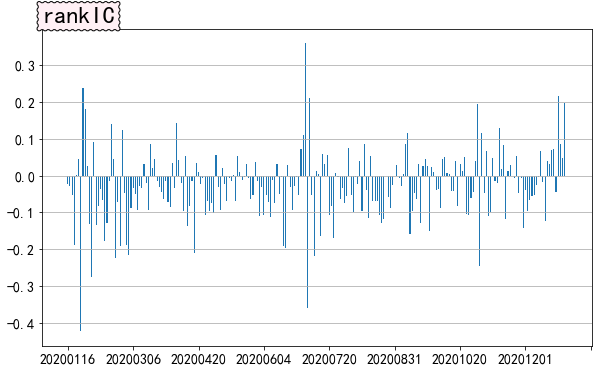

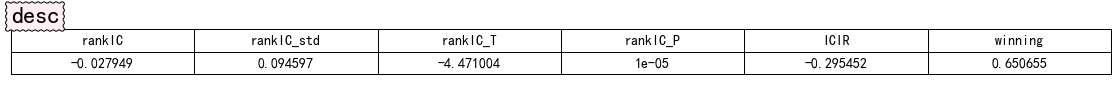

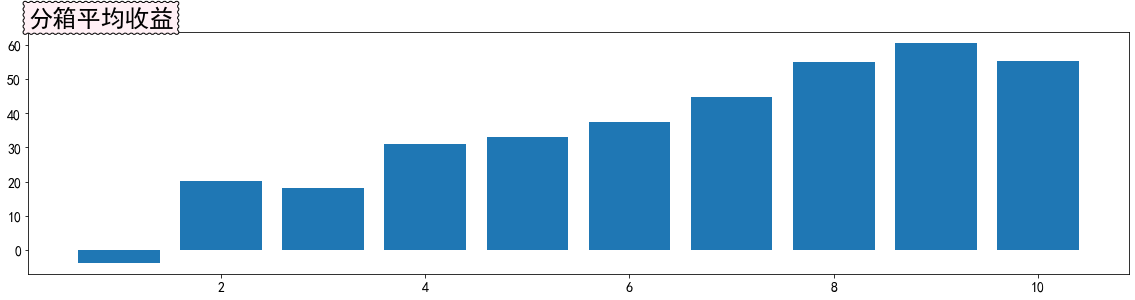

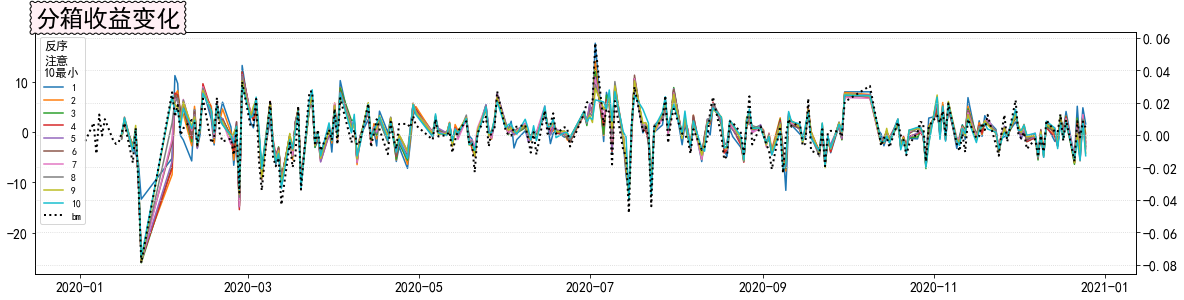

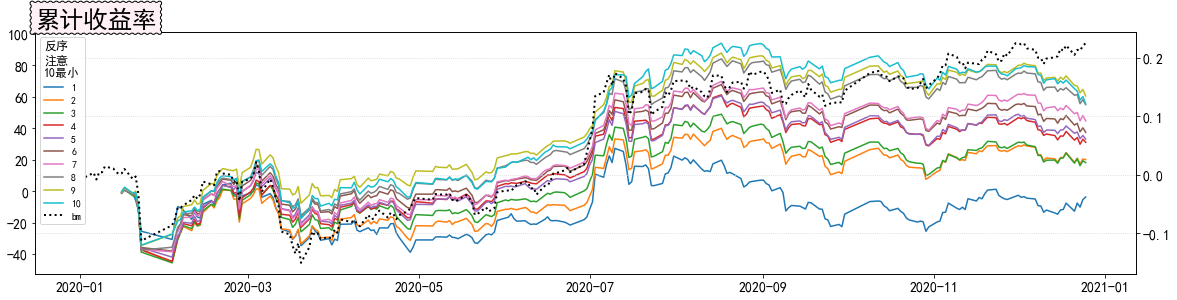

In [28]:
fa = pd.DataFrame(pvc_10).dropna()
fa.columns=['xxx']
test = FactorTest(start=dates.min().strftime('%Y-%m-%d'),end=dates.max().strftime('%Y-%m-%d'),target_field='xxx',blenchmark_name='Ê≤™Ê∑±300', freq="d")
test.process_ind_simple(fa,ret,need_descript=True)
test.plot()


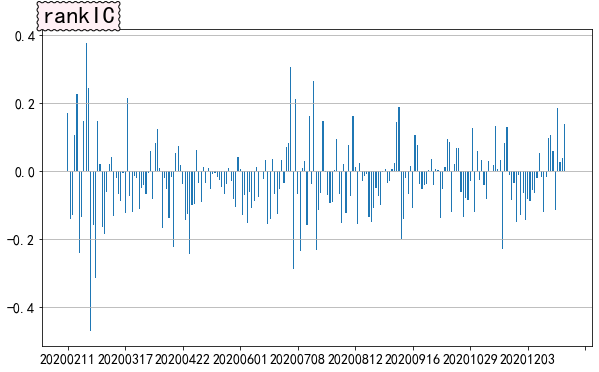

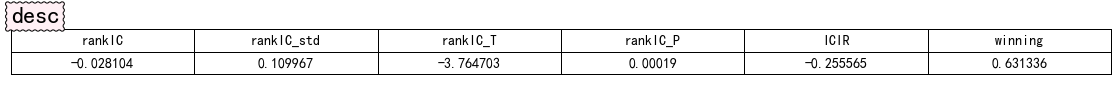

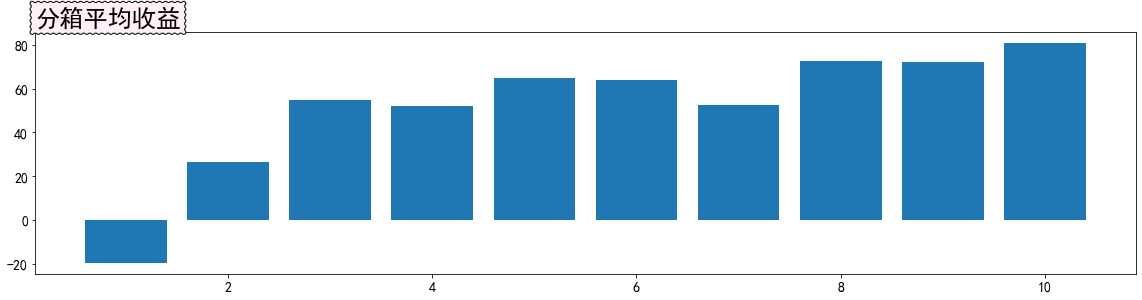

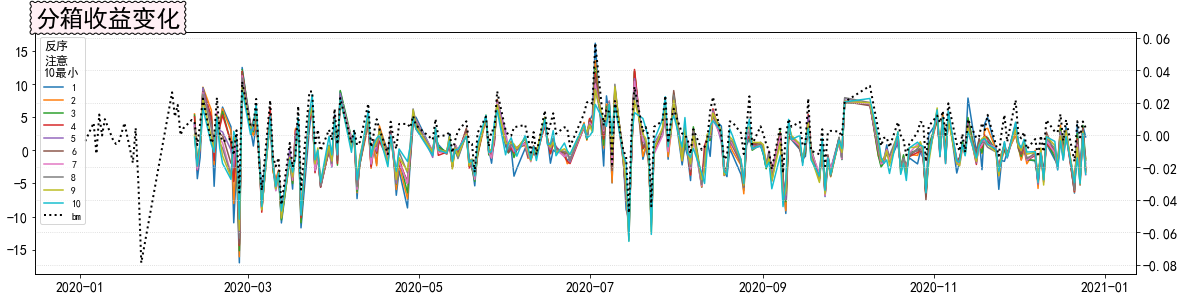

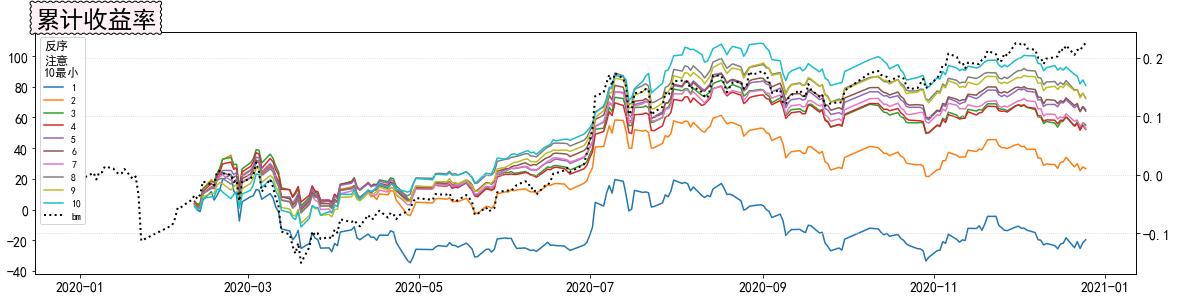

In [29]:
fa = pd.DataFrame(pvc_22).dropna()
fa.columns=['xxx']
test = FactorTest(start=dates.min().strftime('%Y-%m-%d'),end=dates.max().strftime('%Y-%m-%d'),target_field='xxx',blenchmark_name='Ê≤™Ê∑±300', freq="d")
test.process_ind_simple(fa,ret,need_descript=True)
test.plot()
